In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from collections import Counter


from Bio import SeqIO, AlignIO

import diverse_yeast_tools as dyt

#from evcouplings.align import Alignment
#from evcouplings import compare as evcompare
from evcouplings.couplings import read_raw_ec_file

from ete3 import Tree #, SeqMotifFace, TreeStyle, add_face_to_node, RectFace, NodeStyle, TextFace, AttrFace, EvolTree

#from evcouplings.utils import read_config_file
#from evcouplings.utils.pipeline import execute

base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')
y1000plus_dir = os.path.normpath('C:/Users/bheineike/Documents/GitHub/y1000plus_tools') 
y1000_species = pd.read_csv(y1000plus_dir + os.sep + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"), index_col=0)


species_set = pd.read_csv(os.path.normpath(base_dir + '/selected_proteins/species_selection/species_selection.csv'), index_col = 0)
species_set_filt = species_set.loc[species_set['Load']=='Y']
spec_timetree_lookup = dict(zip(species_set_filt['original_genome_id'], species_set_filt['Time_tree_name']))


etc_genes = {'COX9': 'OG4118_REF_Scer_AF-P07255-F1-model_v2'}
mito_genes = {'COX2': 'cox2'}


#Test Case Cox9 and Cox2

Identify species present, 
Build an alignment that has those species in 
Reorder species and 

A) Concatenate and Run EC
B) Run EC on it as two different MSAs

Analysis
Identify residues that have a coevolution signature
Compare with residues with positive selection signature and their near neighbors

Visualize interesting instances

In [72]:
Missing following species from either nuclear or mitochondrial alignments:
{'Komagataella_pastoris', 'Ascoidea_rubescens', 'Starmerella_apicola', 'Vanderwaltozyma_polyspora', 'Alloascoidea_hylecoeti', 'Tortispora_caseinolytica', 'Lipomyces_starkeyi'}

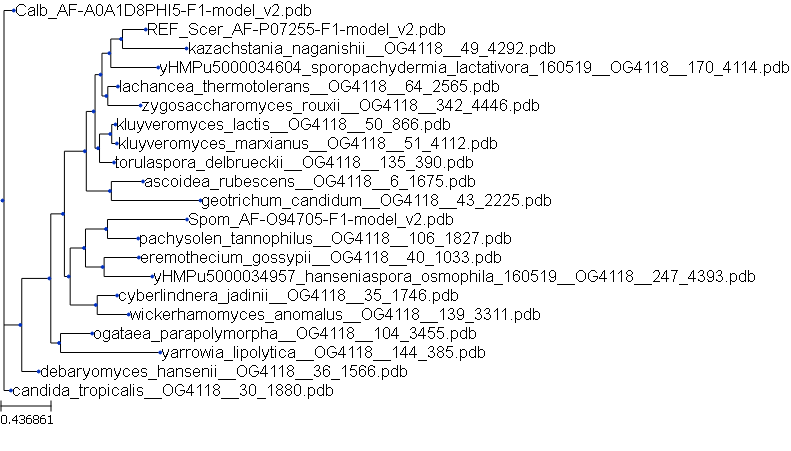

In [2]:
#Visualize Tree for Cox9

tree_fname_base = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')

goi = 'COX9'
og_ref = etc_genes[goi]

fname_tree = tree_fname_base + os.sep + og_ref + '.tm.fasta.clipkit.treefile'

t = Tree(fname_tree, format=1)  
t.ladderize
t.render('%%inline')

G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\examples\etc\mitochondrial_sequences\trees\cox2.tm.fasta.clipkit.treefile


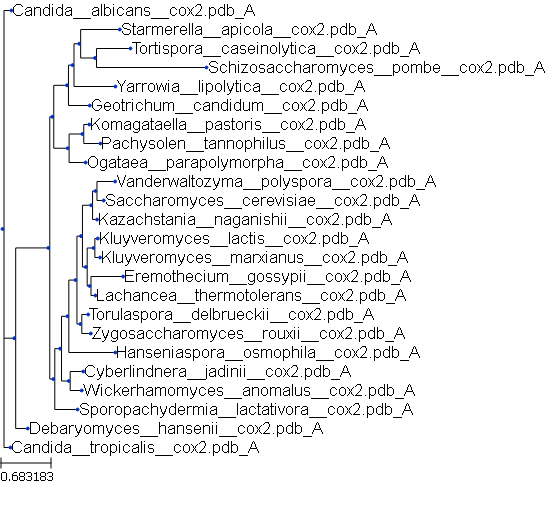

In [ ]:
#Visualize Tree for Cox2
tree_fname_base_mito = base_dir + os.sep + os.path.normpath('examples/etc/mitochondrial_sequences/trees')

goi = 'cox2'


fname_tree = tree_fname_base_mito + os.sep + goi + '.tm.fasta.clipkit.treefile'

t = Tree(fname_tree, format=1)  
t.ladderize
t.render('%%inline')

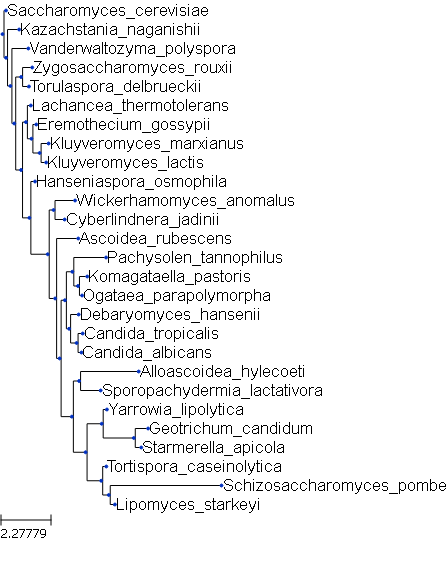

In [46]:
#Visualize Species Tree for selected species

time_tree_fname = base_dir + os.sep + os.path.normpath('selected_proteins/species_selection/species_selection_pombe.nw')
time_tree = Tree(time_tree_fname)
time_tree.unroot()
time_tree.set_outgroup('Saccharomyces_cerevisiae')
time_tree.ladderize
time_tree_leaves = time_tree.get_leaf_names()
time_tree.render('%%inline')


In [115]:
#Identify species present in both and put in tree order

goi_nuc = 'COX9'
goi_mito = 'COX2'

example_dir = base_dir + os.sep + os.path.normpath('examples/etc/coupling_analysis/'+goi_nuc + '_' + goi_mito)

time_tree_fname = base_dir + os.sep + os.path.normpath('selected_proteins/species_selection/species_selection_pombe.nw')
time_tree = Tree(time_tree_fname)
time_tree.unroot()
time_tree.set_outgroup('Saccharomyces_cerevisiae')
time_tree.ladderize
time_tree_leaves = time_tree.get_leaf_names()

#Load Mito Protein Tree: 
tree_fname_base_mito = base_dir + os.sep + os.path.normpath('examples/etc/mitochondrial_sequences/trees')

fname_tree = tree_fname_base_mito + os.sep + mito_genes[goi_mito] + '.tm.fasta.clipkit.treefile'
t_mito = Tree(fname_tree, format=1)  
t_mito_leaves = t_mito.get_leaf_names()

t_mito_leaves_timetree_names = []
t_mito_leaf_spec_lookup = {}

for leaf in t_mito_leaves: 
    leafsp = leaf.split('__')
    timetree_name = leafsp[0] + '_' + leafsp[1]
    t_mito_leaves_timetree_names.append(timetree_name)
    t_mito_leaf_spec_lookup[leaf] = timetree_name

t_mito_leaves_counter = Counter(t_mito_leaves_timetree_names)

#Check for Paralogs
assert np.max(list(t_mito_leaves_counter.values()))==1, 'Warning: Parlogs present - mapping is not simple'

#If no paralogs make a dictionary that looks up each leaf by species name - remove .pdb from leaf name
spec_leaf_lookup_mito = {}
for leaf, spec in t_mito_leaf_spec_lookup.items():
    spec_leaf_lookup_mito[spec] = leaf.split('.pdb')[0]



#Nuc protein
tree_fname_base = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
og_ref = etc_genes[goi_nuc]

fname_tree = tree_fname_base + os.sep + og_ref + '.tm.fasta.clipkit.treefile'

t_nuc = Tree(fname_tree, format=1)  
t_nuc.ladderize

t_nuc_leaves = t_nuc.get_leaf_names()

t_nuc_leaves_timetree_names = []
t_nuc_leaf_spec_lookup = {}

for leaf in t_nuc_leaves: 
    leafsp = leaf.split('.pdb')
    spec_orig, gene_id = dyt.species_from_fasta_id(leafsp[0])
    timetree_name = spec_timetree_lookup[spec_orig] 
    t_nuc_leaves_timetree_names.append(timetree_name)
    t_nuc_leaf_spec_lookup[leaf] = timetree_name

t_nuc_leaves_counter = Counter(t_nuc_leaves_timetree_names)

#Check for Paralogs
assert np.max(list(t_mito_leaves_counter.values()))==1, 'Warning: Parlogs present - mapping is not simple'

#If no paralogs make a dictionary that looks up each leaf by species name - remove .pdb from leaf name
spec_leaf_lookup_nuc = {}
for leaf, spec in t_nuc_leaf_spec_lookup.items():
    spec_leaf_lookup_nuc[spec] = leaf.split('.pdb')[0]


#Identify species present in both alignments 

time_tree_leaves_present = []

time_tree_leaves_present_set = set(t_nuc_leaves_timetree_names) & set(t_mito_leaves_timetree_names)

print('Missing following species from either nuclear or mitochondrial alignments:')
print(set(time_tree_leaves)-time_tree_leaves_present_set)


for leaf in time_tree_leaves: 
    if leaf in time_tree_leaves_present_set:
        time_tree_leaves_present.append(leaf)




#Build new fastas with gene id and species in header in same order as tree

#Mitochondrial gene
mito_aln_fname_out = example_dir + os.sep + goi_mito + '_alignment_sorted.aln'
aln_old_mito = SeqIO.parse(base_dir + os.sep + os.path.normpath('examples/etc/mitochondrial_sequences/pdbs/fasta_renamed/us_align_clean_' + mito_genes[goi_mito] + '.fasta'),'fasta')

aln_old_mito_dict = {}

for record in aln_old_mito:
    record_id = record.id.split('.pdb')[0]
    aln_old_mito_dict[record_id] = record.seq

with open(mito_aln_fname_out, 'w') as f_out_mito: 
    for spec_timetree in time_tree_leaves_present: 
        gene_id = spec_leaf_lookup_mito[spec_timetree]
        f_out_mito.write('>'+ gene_id + ' species=' + spec_timetree + '\n')
        f_out_mito.write(str(aln_old_mito_dict[gene_id]) + '\n')


#Nuclear gene
nuc_aln_fname_out = example_dir + os.sep + goi_nuc + '_alignment_sorted.aln'
aln_old_nuc = SeqIO.parse(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + etc_genes[goi_nuc] + '.tm.fasta'),'fasta')

aln_old_nuc_dict = {}

for record in aln_old_nuc:
    record_id = record.id.split('.pdb')[0]
    aln_old_nuc_dict[record_id] = record.seq

with open(nuc_aln_fname_out, 'w') as f_out_nuc: 
    for spec_timetree in time_tree_leaves_present: 
        gene_id = spec_leaf_lookup_nuc[spec_timetree]
        f_out_nuc.write('>'+ gene_id + ' species=' + spec_timetree + '\n')
        f_out_nuc.write(str(aln_old_nuc_dict[gene_id]) + '\n')


#Concatenate both genes together
concat_aln_fname_out = example_dir + os.sep + goi_nuc + '_' + goi_mito + '_alignment_sorted.aln'


with open(concat_aln_fname_out, 'w') as f_out_nuc: 
    for spec_timetree in time_tree_leaves_present: 
        gene_id_nuc = spec_leaf_lookup_nuc[spec_timetree]
        gene_id_mito = spec_leaf_lookup_mito[spec_timetree]        
        
        seq_nuc = str(aln_old_nuc_dict[gene_id_nuc])
        seq_mito = str(aln_old_mito_dict[gene_id_mito])

        f_out_nuc.write('>'+ gene_id_nuc + '___' + gene_id_mito + ' species=' + spec_timetree + '\n')
        f_out_nuc.write(seq_nuc+seq_mito + '\n')



# nuc_aln_fname_out = example_dir + os.sep + goi_mito + '_alignment_sorted.aln'

# base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
# with open(nuc_aln_fname_out) as f_out_nuc: 
#     for spec_timetree in time_tree_leaves: 



#Run EC on it

#As one concatenated MSA

#As two separate MSAs


Missing following species from either nuclear or mitochondrial alignments:
{'Komagataella_pastoris', 'Ascoidea_rubescens', 'Starmerella_apicola', 'Vanderwaltozyma_polyspora', 'Alloascoidea_hylecoeti', 'Tortispora_caseinolytica', 'Lipomyces_starkeyi'}


# Analysis

Map the residues appropriately to each protein's reference structure
Identify residues that have a Coevolution signature
    Threshold is the absolute value of the minimum score

Compare inter to intra protein signatures
    How many unique molecules for each one? 
    Normalize to the length of the protein

Visualize unique selected residues in Chimera
After loading the appropriate session
base_dir + /examples/etc/coupling_analysis/COX9_COX2/chimera_sessions/aligned_no_coloring.png

mito gene: color sel #d8bd98
nuc gene: color sel cornflower blue

sel <cmd for selecting residues>
color sel red


Take pos selcted residues on Cox9 (nuclear), see if there is any overlap with coevolved residues on cox9 in close proximity to cox2 (mitochondrial) 

In [5]:
#Map index from EC file to each reference structure

goi_nuc = 'COX9'
goi_mito = 'COX2'

example_dir = base_dir + os.sep + os.path.normpath('examples/etc/coupling_analysis/'+goi_nuc + '_' + goi_mito)


nuc_aln_fname = example_dir + os.sep + goi_nuc + '_alignment_sorted.aln'
nuc_aln = AlignIO.read(nuc_aln_fname, format='fasta')

seq_out_nuc, msa2input_nuc, input2msa_nuc, pair_mapping_nuc = dyt.seq_squeeze(nuc_aln[0].seq)
L_nuc_aln = nuc_aln.get_alignment_length()
L_nuc_ref = len(seq_out_nuc)



mito_aln_fname = example_dir + os.sep + goi_mito + '_alignment_sorted.aln'
mito_aln = AlignIO.read(mito_aln_fname, format='fasta')

seq_out_mito, msa2input_mito, input2msa_mito, pair_mapping_mito = dyt.seq_squeeze(mito_aln[0].seq)
L_mito_aln = mito_aln.get_alignment_length()
L_mito_ref = len(seq_out_mito)



concat_aln_fname = example_dir + os.sep + goi_nuc + '_' + goi_mito + '_alignment_sorted.aln'
concat_aln = AlignIO.read(concat_aln_fname, format='fasta')

seq_out_concat, msa2input_concat, input2msa_concat, pair_mapping_concat = dyt.seq_squeeze(concat_aln[0].seq)
L_concat_aln = concat_aln.get_alignment_length()
L_concat_ref = len(seq_out_concat)

#map from concatenated index to final sequence

#ind_map = {ind: (goi, seq_id, seq_ind, msa_ind, res)}
#All indices are 0 based - need to add 1 for PDB numbering in chimera

ind_map = {}

assert L_nuc_ref + L_mito_ref == L_concat_ref, 'Squeezed Nuclear ({}) and Mitochondrial({}) sequences do not equal squeezed concatenated sequence'.format(goi_nuc, goi_mito)

#Numbering of indices from evcouplings starts with 1. My numbering starts with 0 
for jj in range(1,L_nuc_ref + 1):
    ref_gene_id = nuc_aln[0].id
    ref_ind = jj-1
    ref_msa_ind = input2msa_nuc[ref_ind]
    res = seq_out_nuc[ref_ind] 
    ind_map[jj] = (goi_nuc, ref_gene_id, ref_ind, ref_msa_ind, res)

for jj in range(L_nuc_ref + 1, L_nuc_ref+ L_mito_ref + 1):
    ref_gene_id = mito_aln[0].id
    ref_ind = jj-1-L_nuc_ref
    ref_msa_ind = input2msa_mito[ref_ind]
    res = seq_out_mito[ref_ind] 
    ind_map[jj] = (goi_mito, ref_gene_id, ref_ind, ref_msa_ind, res)

#aln_old_mito = SeqIO.parse(base_dir + os.sep + os.path.normpath('examples/etc/mitochondrial_sequences/pdbs/fasta_renamed/us_align_clean_' + mito_genes[goi_mito] + '.fasta'),'fasta')


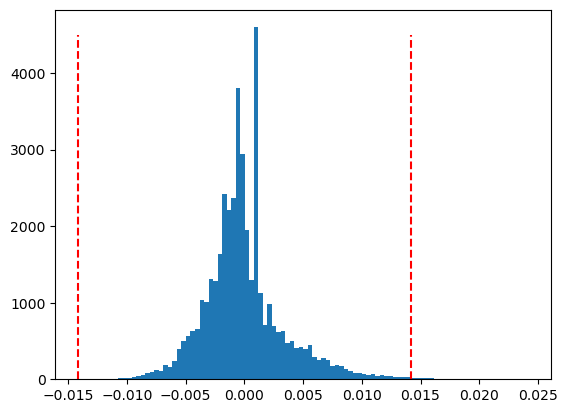

In [68]:
#reads ECs as a pandas df and sorts ECs according to score
ecs = read_raw_ec_file(base_dir + os.sep + os.path.normpath("examples/etc/coupling_analysis/COX9_COX2/COX9_COX2_concat/couplings/COX9_COX2_concat_ECs.txt") )

ecs_noise_thresh = -min(ecs['cn'])


fig, ax = plt.subplots()

ax.hist(ecs['cn'], bins=100)
ax.vlines([-ecs_noise_thresh, ecs_noise_thresh],0,4500,colors = 'r', linestyles='--')


In [69]:
ecs_noise_thresh = -min(ecs['cn'])

hits = ecs.loc[ecs['cn']>ecs_noise_thresh,:]

print('{} hits above ec noise threshold'.format(len(hits)))
#Subset intermolecular and intramolecular

#Dictionary with keys <goi_nuc>_<goi_nuc>, <goi_mito>_<goi_mito>, <goi_nuc>_<goi_mito>
#
#Inside is a list of hits with each hit containing
# (ref_ind_i, ref_aln_ind_i, res_i, ref_ind_j, ref_aln_ind_j, res_j, cn)
# Note that these are python numbered - 0 is first index

hits_processed = {goi_nuc + '_' + goi_nuc : [],
                  goi_mito + '_' + goi_mito : [],
                  goi_nuc + '_' + goi_mito : []
                  }


for hit_ind, hit in hits.iterrows(): 
    mol_i_info = ind_map[hit['i']]
    mol_i_name = mol_i_info[0]
    assert mol_i_info[4] == hit['A_i'], 'Residue Mismatch {} {}{}'.format(mol_i_name, mol_i_info[2], mol_i_info[4])
    
    mol_j_info = ind_map[hit['j']]
    mol_j_name = mol_j_info[0]
    assert mol_j_info[4] == hit['A_j'], 'Residue Mismatch {} {}{}'.format(mol_j_name, mol_j_info[2], mol_j_info[4])

    assert hit['i']<hit['j'], 'indices not sorted, hit: {}'.format(hit_ind)

    hit_entry = (mol_i_info[2],mol_i_info[3], mol_i_info[4], mol_j_info[2],mol_j_info[3], mol_j_info[4], hit['cn'] )

    if mol_i_name == mol_j_name:   # Intermolecular
        hits_processed[mol_i_name + '_' + mol_j_name].append(hit_entry)
    else: 
        hits_processed[goi_nuc + '_' + goi_mito].append(hit_entry)



138 hits above ec noise threshold


In [76]:
#Number of hits

norm_factor = {goi_nuc + '_' + goi_nuc: L_nuc_ref,
            goi_mito + '_' + goi_mito: L_mito_ref,
            goi_nuc + '_' + goi_mito: L_concat_ref
            }

hit_list_decoupled_counter = {}  #NOte that this is in PDB numbering - first coordinate is 1

for key, hit_list in hits_processed.items(): 
    print(key)
    print('N hits: {}'.format(len(hit_list)))
    

    if key in {goi_nuc + '_' + goi_nuc, goi_mito + '_' + goi_mito}:
        hit_list_decoupled = []
        for hit in hit_list:
            hit_list_decoupled.append(hit[2]+str(hit[0]+1))
            hit_list_decoupled.append(hit[5]+str(hit[3]+1))
        
        hit_list_decoupled_counter[key] = Counter(hit_list_decoupled)

        print('Unique Residues: {}'.format(len(hit_list_decoupled_counter[key])))
        print('Unique Residues / protein length: {:0.2}'.format(len(hit_list_decoupled_counter[key])/norm_factor[key]))
    else: 
        #Note that this is in PDB numbering - first coordinate is 1
        hit_list_decoupled_inter_nuc = []
        hit_list_decoupled_inter_mito = []

        hit_list_decoupled_counter_inter = {}

        for hit in hit_list:
            hit_list_decoupled_inter_nuc.append(hit[2]+str(hit[0]+1))
            hit_list_decoupled_inter_mito.append(hit[5]+str(hit[3]+1))
                
        hit_list_decoupled_counter_inter[goi_nuc] = Counter(hit_list_decoupled_inter_nuc)
        hit_list_decoupled_counter_inter[goi_mito] = Counter(hit_list_decoupled_inter_mito)

        print('Unique Residues Intermolecular Coevolution:\n    {}: {}\n    {}: {}'.format(
            goi_nuc, len(hit_list_decoupled_counter_inter[goi_nuc]),
            goi_mito, len(hit_list_decoupled_counter_inter[goi_mito])
            ))
        
        print('Unique Residues Intermolecular Coevolution / protein length:\n    {}: {:0.2}\n    {}: {:0.2}'.format(
            goi_nuc, len(hit_list_decoupled_counter_inter[goi_nuc])/norm_factor[goi_nuc + '_' + goi_nuc],
            goi_mito, len(hit_list_decoupled_counter_inter[goi_mito])/norm_factor[goi_mito + '_' + goi_mito]
            ))
        

#Percentage of hits

#Number of unique residues



COX9_COX9
N hits: 6
Unique Residues: 9
Unique Residues / protein length: 0.15
COX2_COX2
N hits: 83
Unique Residues: 81
Unique Residues / protein length: 0.32
COX9_COX2
N hits: 49
Unique Residues Intermolecular Coevolution:
    COX9: 24
    COX2: 40
Unique Residues Intermolecular Coevolution / protein length:
    COX9: 0.41
    COX2: 0.16


Unique Residues Intermolecular Coevolution:
    COX9: 24
    COX2: 40


In [58]:
hit_list_decoupled_counter[goi_nuc + '_' + goi_nuc]

Counter({'E45': 2,
         'A52': 2,
         'L51': 2,
         'T9': 1,
         'R13': 1,
         'L20': 1,
         'A49': 1,
         'W32': 1,
         'G35': 1})

In [ ]:
1 numbered
L24 - Proximity, coevolve
G26 - Proximity, coevolve
M28 - Proximity
W32 - Proximity, coevolve
W34 - 
F36 - Proximity, coevolve
A52 - coevolve

In [61]:
hits_processed['COX9_COX2']

[(12, 76, 'R', 194, 270, 'I', 0.02074),
 (38, 102, 'D', 91, 166, 'I', 0.020651),
 (30, 94, 'Y', 68, 143, 'P', 0.020276),
 (12, 76, 'R', 69, 144, 'I', 0.019529),
 (46, 110, 'F', 31, 104, 'N', 0.018708),
 (46, 110, 'F', 170, 246, 'V', 0.01861),
 (28, 92, 'A', 48, 121, 'V', 0.018571),
 (30, 94, 'Y', 151, 227, 'L', 0.018239),
 (12, 76, 'R', 75, 150, 'K', 0.017752),
 (35, 99, 'F', 55, 128, 'W', 0.017654),
 (15, 79, 'M', 20, 93, 'Y', 0.017502),
 (52, 116, 'E', 20, 93, 'Y', 0.01749),
 (30, 94, 'Y', 135, 211, 'D', 0.017099),
 (10, 74, 'K', 138, 214, 'E', 0.017067),
 (11, 75, 'R', 151, 227, 'L', 0.016953),
 (40, 104, 'I', 36, 109, 'L', 0.016479),
 (7, 71, 'G', 204, 280, 'N', 0.016348),
 (35, 99, 'F', 151, 227, 'L', 0.016136),
 (35, 99, 'F', 230, 306, 'N', 0.016014),
 (14, 78, 'I', 87, 162, 'F', 0.016009),
 (40, 104, 'I', 164, 240, 'T', 0.015975),
 (25, 89, 'G', 150, 226, 'E', 0.015721),
 (11, 75, 'R', 91, 166, 'I', 0.015696),
 (46, 110, 'F', 167, 243, 'V', 0.015589),
 (44, 108, 'E', 194, 270, '

In [60]:
hit_list_decoupled_counter_inter[goi_nuc]

Counter({'R13': 5,
         'K11': 4,
         'I41': 4,
         'Y31': 3,
         'F47': 3,
         'F36': 3,
         'E53': 3,
         'R12': 2,
         'G8': 2,
         'G26': 2,
         'E45': 2,
         'G21': 2,
         'V19': 2,
         'I10': 2,
         'D39': 1,
         'A29': 1,
         'M16': 1,
         'I15': 1,
         'K56': 1,
         'A52': 1,
         'L24': 1,
         'M38': 1,
         'W32': 1,
         'L51': 1})

In [45]:
chain_dict = {goi_nuc: '#2/A', 
              goi_mito: '#1/A'}

chimera_sel_coupled_res_intra = {}

for goi in [goi_nuc, goi_mito]: 
    hits_to_color = list(hit_list_decoupled_counter[goi + '_' + goi].keys())

    cmd = 'select '+ chain_dict[goi] + ':'

    cmd = cmd + hits_to_color[0][1:]
    for jj in range(1,len(hits_to_color)):
        cmd = cmd + ',' + hits_to_color[jj][1:]
    
    chimera_sel_coupled_res_intra[goi] = cmd

cmd = 'select '

for goi in [goi_nuc, goi_mito]: 
    hits_to_color = list(hit_list_decoupled_counter_inter[goi].keys())

    cmd = cmd + chain_dict[goi] + ':'

    cmd = cmd + hits_to_color[0][1:]
    for jj in range(1,len(hits_to_color)):
        cmd = cmd + ',' + hits_to_color[jj][1:]
    
    cmd = cmd + ' '

chimera_sel_coupled_res_inter = cmd


In [46]:
chimera_sel_coupled_res_inter

'select #2/A:13,39,31,47,29,36,16,53,11,12,41,8,15,26,45,56,21,52,24,19,38,32,51,10 #1/A:195,92,69,70,32,171,49,152,76,56,21,136,139,37,205,231,88,165,151,168,29,180,119,23,210,178,48,241,75,59,94,13,159,214,97,74,115,142,87,61 '

In [49]:
hits_processed[goi_nuc + '_' + goi_mito]

[(12, 76, 'R', 194, 270, 'I', 0.02074),
 (38, 102, 'D', 91, 166, 'I', 0.020651),
 (30, 94, 'Y', 68, 143, 'P', 0.020276),
 (12, 76, 'R', 69, 144, 'I', 0.019529),
 (46, 110, 'F', 31, 104, 'N', 0.018708),
 (46, 110, 'F', 170, 246, 'V', 0.01861),
 (28, 92, 'A', 48, 121, 'V', 0.018571),
 (30, 94, 'Y', 151, 227, 'L', 0.018239),
 (12, 76, 'R', 75, 150, 'K', 0.017752),
 (35, 99, 'F', 55, 128, 'W', 0.017654),
 (15, 79, 'M', 20, 93, 'Y', 0.017502),
 (52, 116, 'E', 20, 93, 'Y', 0.01749),
 (30, 94, 'Y', 135, 211, 'D', 0.017099),
 (10, 74, 'K', 138, 214, 'E', 0.017067),
 (11, 75, 'R', 151, 227, 'L', 0.016953),
 (40, 104, 'I', 36, 109, 'L', 0.016479),
 (7, 71, 'G', 204, 280, 'N', 0.016348),
 (35, 99, 'F', 151, 227, 'L', 0.016136),
 (35, 99, 'F', 230, 306, 'N', 0.016014),
 (14, 78, 'I', 87, 162, 'F', 0.016009),
 (40, 104, 'I', 164, 240, 'T', 0.015975),
 (25, 89, 'G', 150, 226, 'E', 0.015721),
 (11, 75, 'R', 91, 166, 'I', 0.015696),
 (46, 110, 'F', 167, 243, 'V', 0.015589),
 (44, 108, 'E', 194, 270, '

One pairing that looks physically close: 
(28, 92, 'A', 48, 121, 'V', 0.018571)
cox9 A29, 
cox2 V49

for this when cox9 29 residue is A, Cox2 49 residue is often Leucine, and when cox9 is Glycine, cox2 is often Leucine, but this isn't always true. 

Contacts (0 numered from Oliver's algorithm) are:

cox9 to cox2
i_b

[W34, F22, L24, G26, S30] pos selected contacts

These ones don't look pos sel




Used crystal structure indices, and may be off by 2. 
Off by 2

Use crystalstructure indices

PDB:  start at 0 depending on what the index shift



zero numbered: 
S23 (looks wrong)
G25 (looks right)
V27(looks wrong)
T31 (looks wrong)
G35 (looks wrong)


1 Numbered
F22 (looks on the side) 
L24 (possibly but G25 would be better)
G26 (possibly but G25 would be better)
S30 (looks wrong)
W34 (looks wrong)

Pos sel:  

0 numbered
"L23",
"W31",
"W33",
"F35",
"A51",
"G25",
"M27"

b_i res: 
[L22, G24, M26, W30, F34] 
L24, G26, M28, W32, F26

cox9
0 - 2

pos sel: 
L24, G26, W34

not pos sel
F22, S30, 

1 numbered
L24 - Proximity, coevolve
G26 - Proximity, coevolve
M28 - 
W32 - coevolve
W34 - Proximity
F36 - coevolve
A52 - coevolve


L24 pos sel
G26 pos sel

In [54]:
with open(base_dir + os.sep + os.path.normpath('examples/etc/selection_analysis/contacts.pkl'), 'rb') as f_in:
    contacts = pkl.load(f_in)

In [57]:
for key, item in contacts.items():
    if key == 'i_b':
        print(key)
        print(item)

i_b
[34, 22, 24, 26, 30]


In [52]:
len(Counter(hits['j']).keys())

74

(array([5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 1.000e+01, 8.000e+00, 2.100e+01, 2.300e+01, 1.800e+01,
        2.700e+01, 4.400e+01, 5.000e+01, 8.400e+01, 9.300e+01, 1.250e+02,
        1.060e+02, 1.890e+02, 1.650e+02, 2.360e+02, 3.950e+02, 5.050e+02,
        5.690e+02, 6.300e+02, 6.520e+02, 1.037e+03, 1.011e+03, 1.314e+03,
        1.290e+03, 1.633e+03, 2.421e+03, 2.207e+03, 2.374e+03, 3.800e+03,
        2.940e+03, 1.948e+03, 1.302e+03, 4.598e+03, 1.132e+03, 7.120e+02,
        9.800e+02, 7.010e+02, 6.190e+02, 6.300e+02, 4.750e+02, 5.010e+02,
        4.100e+02, 4.240e+02, 3.980e+02, 4.420e+02, 2.970e+02, 2.470e+02,
        2.780e+02, 2.500e+02, 1.670e+02, 1.890e+02, 1.760e+02, 1.390e+02,
        1.080e+02, 8.700e+01, 8.300e+01, 7.300e+01, 6.200e+01, 6.700e+01,
        4.200e+01, 5.200e+01, 3.700e+01, 4.300e+01, 3.500e+01, 2.400e+01,
        2.700e+01, 2.400e+01, 2.000e+01, 1.800e+01, 1.700e+01, 1.500e+01,
        1.900e+01, 4.000e+00, 7.000e+0

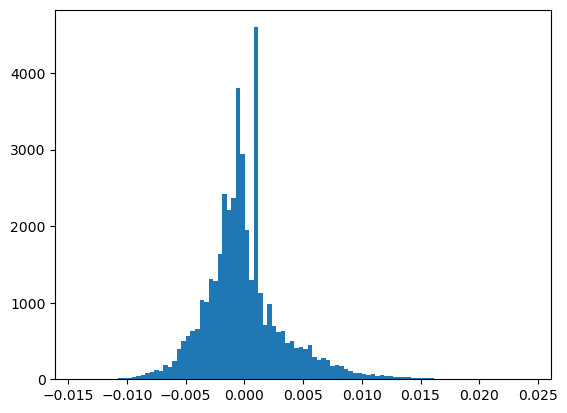

In [3]:

#ax.hist([1,1,1,1,4,4,4,3,3,3,3,2,2,2,2,0,5])


(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 7.000e+00, 3.000e+00, 6.000e+00,
        8.000e+00, 1.000e+01, 1.400e+01, 1.200e+01, 1.100e+01, 2.700e+01,
        2.300e+01, 3.400e+01, 3.300e+01, 1.400e+02, 1.880e+02, 1.870e+02,
        2.120e+02, 3.160e+02, 4.390e+02, 3.080e+02, 3.680e+02, 3.090e+02,
        3.480e+02, 4.380e+02, 4.430e+02, 1.192e+03, 1.545e+03, 1.405e+03,
        1.839e+03, 2.096e+03, 1.924e+03, 3.961e+03, 7.230e+02, 8.700e+02,
        1.104e+03, 3.217e+03, 3.230e+02, 3.250e+02, 2.790e+02, 2.610e+02,
        2.440e+02, 2.160e+02, 2.780e+02, 2.620e+02, 3.050e+02, 2.090e+02,
        2.020e+02, 1.180e+02, 1.540e+02, 1.080e+02, 1.330e+02, 1.620e+02,
        8.300e+01, 7.600e+01, 1.290e+02, 1.850e+02, 5.800e+01, 5.300e+01,
        5.200e+01, 4.800e+01, 5.700e+01, 4.800e+01, 3.800e+01, 2.700e+01,
        4.000e+01, 2.500e+01, 2.000e+01, 1.800e+01, 1.400e+01, 1.300e+01,
        1.400e+01, 1.200e+01, 1.300e+0

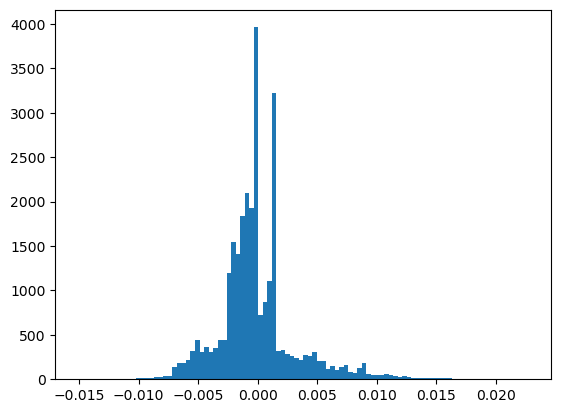

In [114]:
#reads ECs as a pandas df and sorts ECs according to score
ecs = read_raw_ec_file(base_dir + os.sep + os.path.normpath("examples/etc/coupling_analysis/COX9_COX2/COX2/couplings/COX2_ECs.txt") )


fig, ax = plt.subplots()

ax.hist(ecs['cn'], bins=100)

#ax.hist([1,1,1,1,4,4,4,3,3,3,3,2,2,2,2,0,5])

